In [17]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sn

# Introduction to Machine Learning: Supervised Learning

## Introduction and Problem Description

Welcome to my final project for DTSA-5509! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed above. Also if you intend to run this notebook, ensure to place the folder extracted from the data source called "Rice_Images_Dataset" containing the image data into a fresh directory called "data", and set your local directory to contain "data". As a note, the dataset is reasonably large (~1 GB), so download may take a while. Thanks for taking the time to grade my work!

For this project I wanted to do machine learning models on fantasy football data. 

I'll use two different ML models that we learned in this course:

A KNN Classifier

An AdaBoost Classifier

A Random Forest Classifier

In [20]:
weekly_nfl = nfl.import_weekly_data(years=[2024])
print(weekly_nfl.columns)

Downcasting floats.
Index(['player_id', 'player_name', 'player_display_name', 'position', 'position_group', 'headshot_url', 'recent_team', 'season', 'week', 'season_type', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr'], dtype='object')


In [54]:
# Filter the data for Wide Receivers (WR)

wr_data = weekly_nfl[weekly_nfl['position'] == 'WR']

# Sort the data by 'fantasy_points_ppr' in descending order

sorted_wr_data = wr_data.sort_values(by='fantasy_points_ppr', ascending=False)

df = sorted_wr_data

# Display the first few rows of the sorted data

#print(sorted_wr_data.head())
# Select specific columns to display

columns_to_display = ['player_id', 'player_name', 'player_display_name', 'recent_team' , 'week', 'opponent_team', 'fantasy_points_ppr' , 'target_share' ,'targets', 'receptions', 'receiving_yards', 'receiving_epa', 'rushing_yards']

# Display the sorted data with selected columns
print(sorted_wr_data[columns_to_display].head(5))

# Optionally, adjust pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set display width
pd.set_option('display.max_colwidth', 20)   # Set max column width

       player_id player_name player_display_name recent_team  week opponent_team  fantasy_points_ppr  target_share  targets  receptions  receiving_yards  receiving_epa  rushing_yards
643   00-0036259  J.Jennings      Jauan Jennings          SF     3            LA               46.50          0.40       12          11           175.00          15.50           0.00
816   00-0036900     J.Chase       Ja'Marr Chase         CIN     5           BAL               41.30          0.31       12          10           193.00          12.57           0.00
897   00-0037238    D.London        Drake London         ATL     5            TB               33.40          0.24       13          12           154.00          12.69           0.00
1321  00-0039146      J.Reed         Jayden Reed          GB     1           PHI               33.10          0.19        6           4           138.00           8.75          33.00
750   00-0036554   N.Collins        Nico Collins         HOU     4           JAX     

In [67]:
#This cell prints the features we will be using in the EDA, along with information about EDAdata. All other features in Rice_MSC_Dataset seem to be statistical calculations, which may not have 
## direct physical meaning (have to do with orientation on image?)

# List of columns to include
columns_to_include = [
    'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 'receptions', 'targets', 'receiving_yards',
    'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
    'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr'
]

# Filter the DataFrame to include only the specified columns
filtered_df = df[columns_to_include]

# Generate and display the summary statistics
summary = filtered_df.describe().round(2)
print("Summary Statistics for Selected Columns:")
display(summary.style.set_table_attributes("style='display:inline'").set_caption("Summary Statistics"))

Summary Statistics for Selected Columns:


,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,97.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,600.000000,614.000000,599.000000,600.000000,600.000000,600.000000,614.000000,614.000000,614.000000
mean,0.220000,1.140000,0.010000,0.000000,0.000000,0.070000,0.090000,3.080000,4.900000,38.230000,0.230000,0.020000,0.010000,51.360000,13.730000,1.800000,0.970000,0.000000,0.860000,0.160000,0.220000,0.400000,0.010000,5.450000,8.530000
std,0.640000,4.180000,0.120000,0.060000,0.060000,0.270000,1.440000,2.510000,3.570000,35.380000,0.490000,0.140000,0.110000,45.070000,16.210000,1.720000,3.680000,0.060000,0.940000,0.100000,0.170000,0.260000,0.080000,5.760000,7.750000
min,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,-5.640000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,-15.000000,-6.000000,0.000000,-12.850000,0.000000,-0.070000,0.020000,-0.070000,0.020000,0.000000,-0.200000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,1.000000,2.000000,10.000000,0.000000,0.000000,0.000000,15.000000,2.000000,0.000000,-1.170000,0.000000,0.310000,0.080000,0.080000,0.190000,0.000000,1.200000,2.430000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,3.000000,4.000000,29.000000,0.000000,0.000000,0.000000,42.000000,8.000000,1.000000,0.420000,0.000000,0.700000,0.140000,0.200000,0.360000,0.000000,3.300000,6.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.930000,4.000000,7.000000,59.000000,0.000000,0.000000,0.000000,76.000000,20.000000,3.000000,3.110000,0.000000,1.110000,0.230000,0.330000,0.570000,0.000000,8.200000,12.800000
max,8.000000,37.000000,1.000000,1.000000,1.000000,2.000000,3.380000,14.000000,22.000000,193.000000,3.000000,1.000000,1.000000,245.000000,97.000000,9.000000,15.500000,1.000000,9.330000,0.670000,0.760000,1.520000,1.000000,35.500000,46.500000


<Axes: >

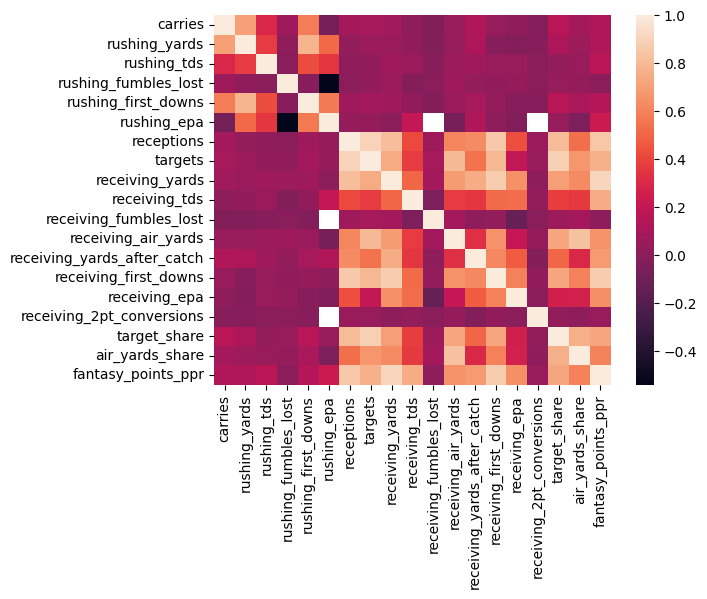

In [73]:
# List of columns you want to include in the cor3relation matrix
columns_to_include = [
    'carries',
    'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'target_share', 'air_yards_share',
    'fantasy_points_ppr'
]

# Select only the columns you want
selected_data = sorted_wr_data[columns_to_include]

# Filter out non-numeric columns
numeric_data = selected_data.select_dtypes(include=['number'])

# Create the correlation matrix
corrMatrix = numeric_data.corr()

sn.heatmap(corrMatrix)


## Matrix Analysis


1.    Strong Positive Correlations:

        - receptions and targets (0.90): This suggests that as the number of receptions increases, the number of targets also tends to increase, which is expected.
        
        - receiving_yards and fantasy_points_ppr (0.91): This indicates that higher receiving yards are strongly associated with higher fantasy points in PPR (points per reception) leagues.
        
        - fantasy_points and fantasy_points_ppr (0.97): This very high correlation is expected since both metrics are closely related, with PPR adding points for receptions.
        
3.    Moderate Positive Correlations:
        
        - rushing_yards and rushing_first_downs (0.78): More rushing yards are associated with more first downs, which makes sense in a football context.
        
        - receiving_yards and receiving_first_downs (0.87): More receiving yards are associated with more first downs.
  
4.    Weak or No Correlations:
        
        - rushing_yards and rushing_first_downs (0.78): More rushing yards are associated with more first downs, which makes sense in a football context.
        
        - rushing_fumbles and most other variables: The correlations are very low, indicating little to no linear relationship with other metrics.

        - special_teams_tds and most other variables: This metric shows very low correlation with others, suggesting it doesn't strongly relate to the other performance metrics.

6.    Negative Correlations:

        - rushing_epa and rushing_fumbles (-0.54): This suggests that more fumbles are associated with a lower expected points added (EPA) from rushing, which is logical as fumbles can negatively impact a team's performance.


## Pair Plot

Pair plot is a fast way to inspect relationships between features. Use seaborn's .pairplot() function to draw a pairplot if the first 10 columns (including price) and inspect their relationships. Set the diagonal elements to be KDE plot. The resulting plot will look like below.

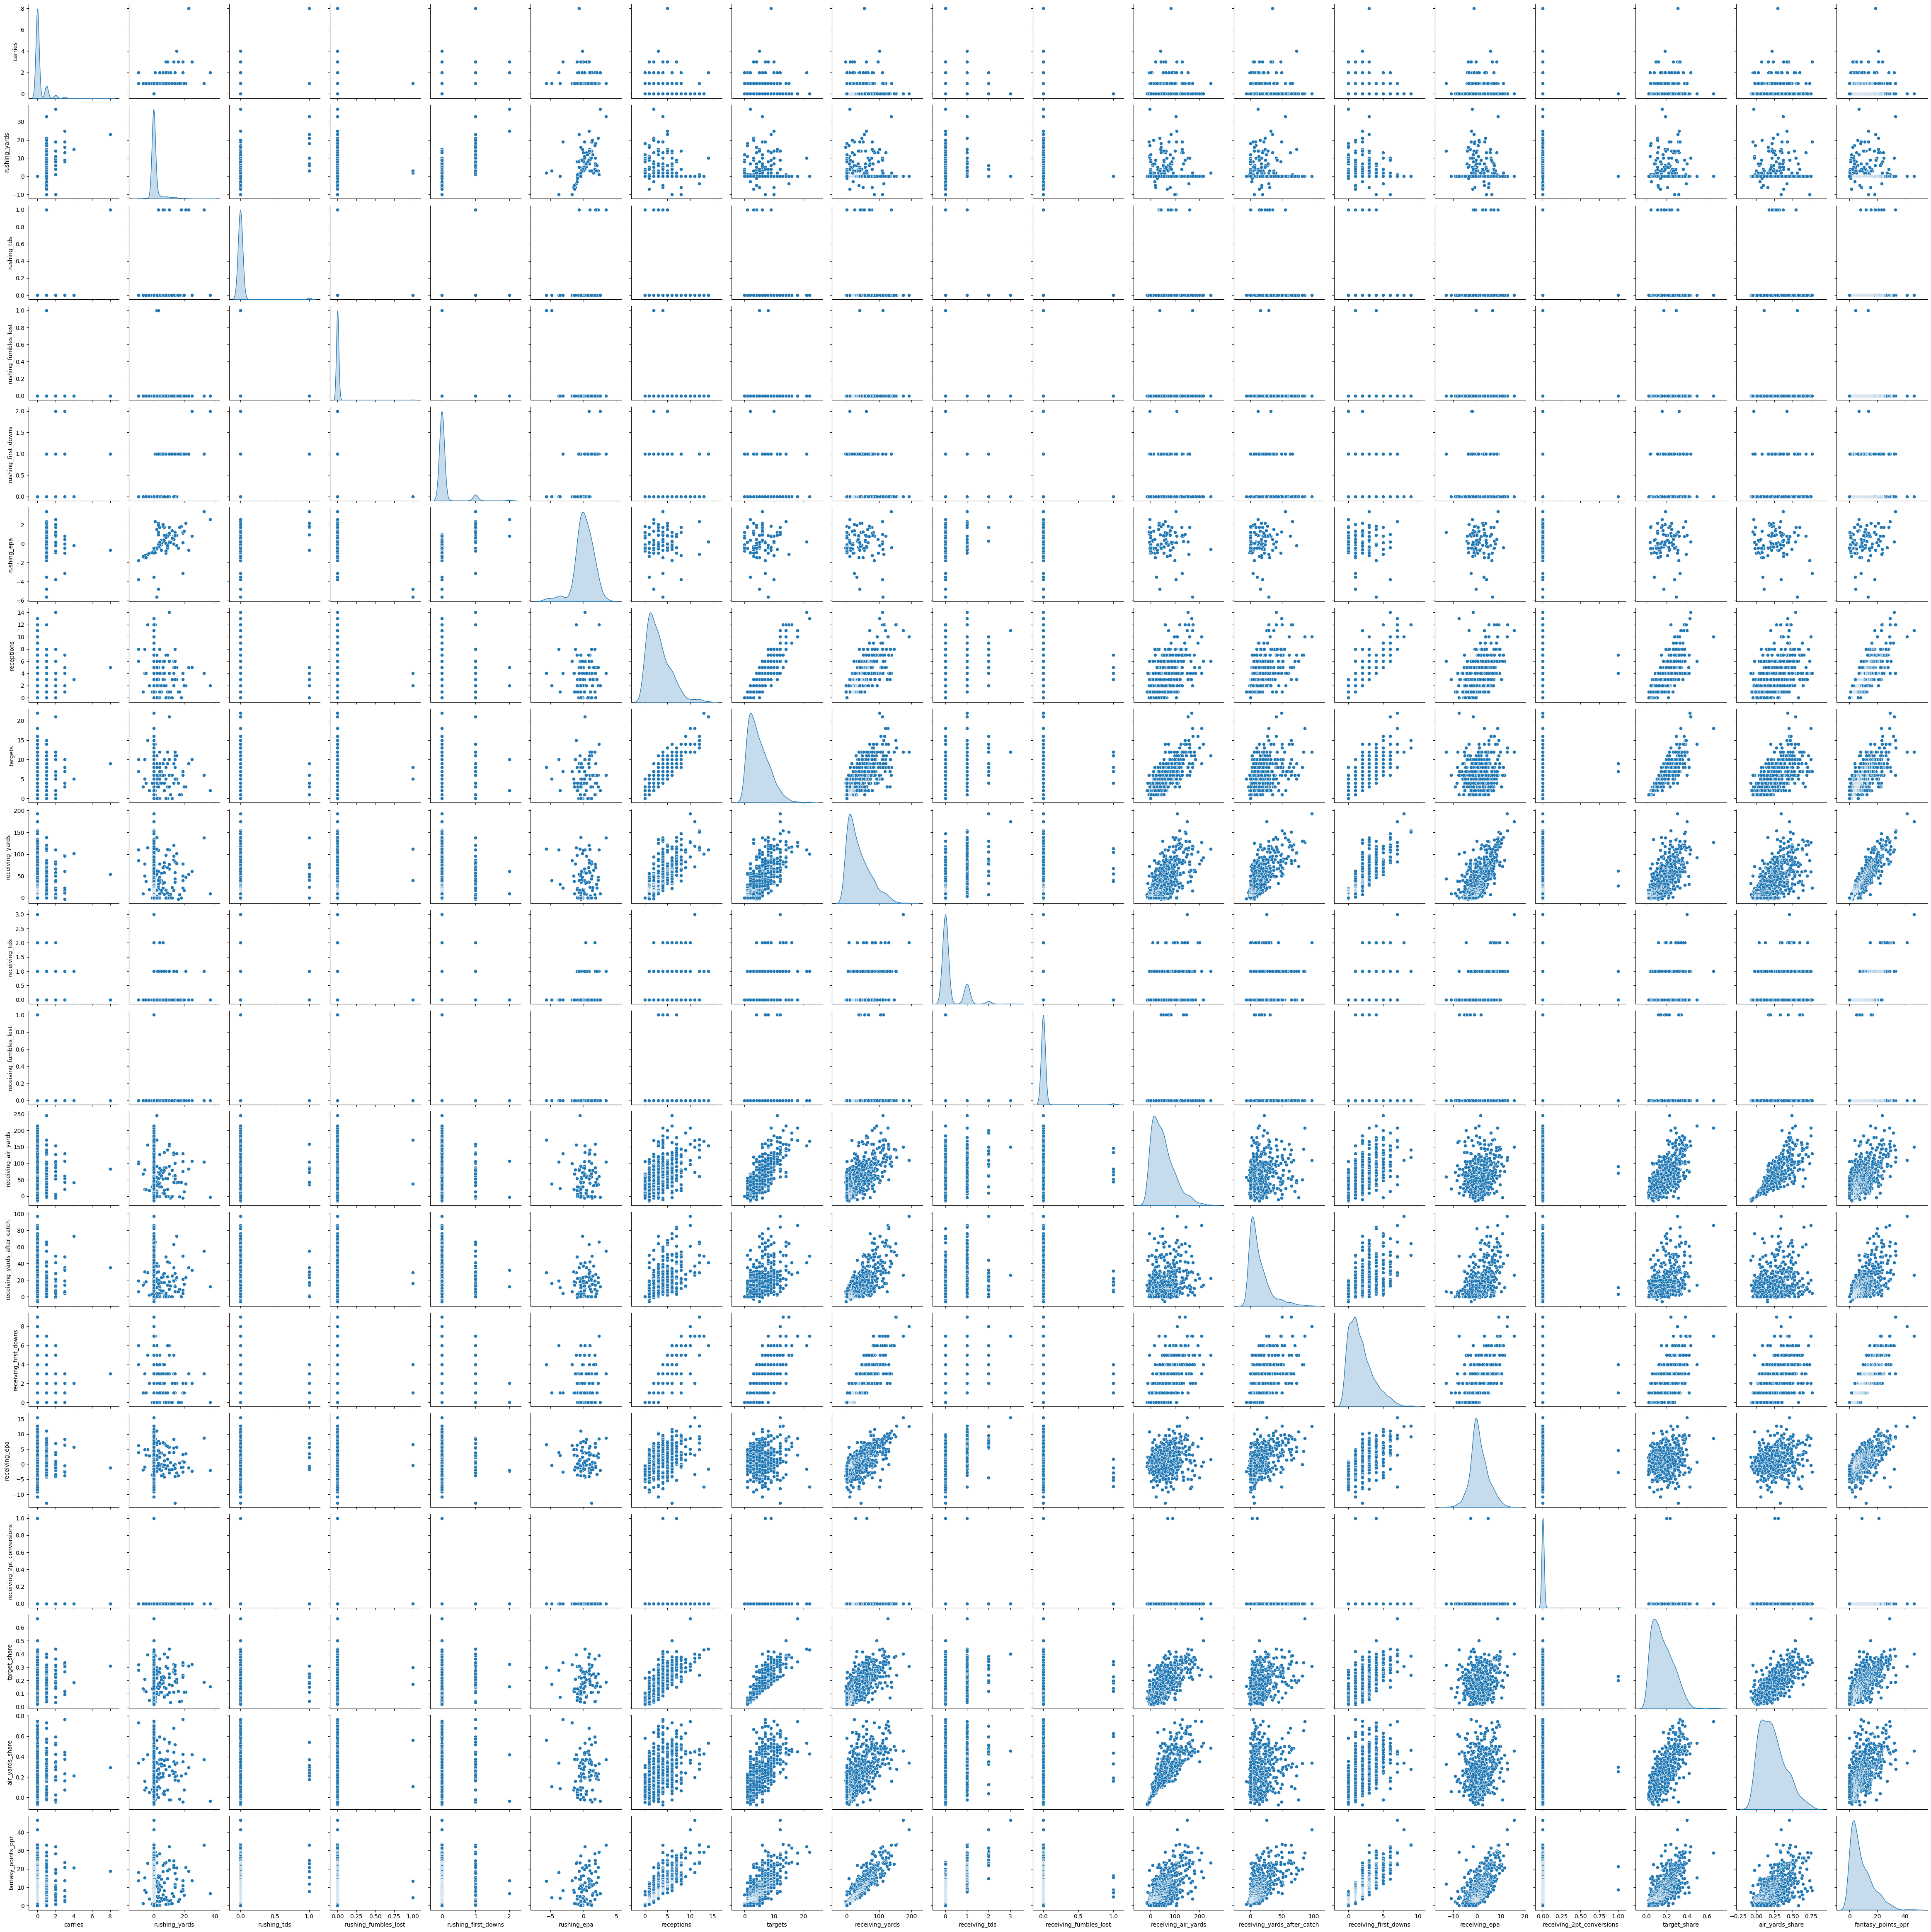

In [74]:
# Create the pair plot
sns.pairplot(df[columns_to_include], diag_kind='kde')

# Show the plot
plt.show()

## Splitting Fantasy Data into Training and Testing Sets

This guide demonstrates how to use the train_test_split function from the sklearn.model_selection module to divide your fantasy data into training and testing subsets. By splitting the data, you can train your machine learning models on one portion and evaluate their performance on another, ensuring a robust assessment of the model's predictive capabilities. The example provided uses an 80/20 split, but you can adjust the test_size parameter to suit your needs.

In [75]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame containing the fantasy data
# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Print the lengths of the training and testing sets
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")

Length of X_train: 491
Length of X_test: 123


## Train a simple linear regression model

This section demonstrates how to build and train a simple linear regression model using your fantasy data. The process involves splitting the data into training and testing sets, selecting a predictor, and evaluating the model's performance using the adjusted R-squared value.

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

# Assuming 'df' is your DataFrame containing the fantasy data
# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Define the best_guess_predictor (for example, let's use 'carries')
best_guess_predictor = 'target_share'

# Build and train the simple linear regression model
model = smf.ols(formula=f'fantasy_points ~ {best_guess_predictor}', data=X_train).fit()

# Print the result summary
print(model.summary())

# Update the adjusted R-squared value according to the result
adj_R2 = model.rsquared_adj
print(f"Adjusted R-squared value: {adj_R2:.4f}")

                            OLS Regression Results                            
Dep. Variable:         fantasy_points   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     277.1
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           2.35e-49
Time:                        11:12:53   Log-Likelihood:                -1408.8
No. Observations:                 477   AIC:                             2822.
Df Residuals:                     475   BIC:                             2830.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0655      0.395     -0.166   

## Best Predictor

In the last section we guessed what would be the best predictor, now we are going to test to see what the top 3 predictors actually are 

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

# Assuming df is your DataFrame and it's already loaded

# Select a subset of predictors with minimal missing values
selected_predictors = ['carries',
    'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'target_share', 'air_yards_share']

# Impute missing values with the mean for the selected predictors
imputer = SimpleImputer(strategy='mean')
df[selected_predictors] = imputer.fit_transform(df[selected_predictors])

# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Ensure the target variable is numeric
X_train['fantasy_points_ppr'] = pd.to_numeric(X_train['fantasy_points_ppr'], errors='coerce')

# Check if the dataset is empty after imputing missing values
if X_train.empty:
    print("The dataset is empty after imputing missing values. Please check your data.")
else:
    # Dictionary to store adjusted R-squared values
    adj_r2_values = {}

    # Fit a simple linear regression model for each selected predictor
    for predictor in selected_predictors:
        model = smf.ols(formula=f'fantasy_points_ppr ~ {predictor}', data=X_train).fit()
        adj_r2_values[predictor] = model.rsquared_adj

    # Convert the dictionary to a DataFrame for easier sorting
    adj_r2_df = pd.DataFrame(list(adj_r2_values.items()), columns=['Predictor', 'Adjusted R-squared'])

    # Sort the DataFrame by adjusted R-squared values in descending order
    adj_r2_df = adj_r2_df.sort_values(by='Adjusted R-squared', ascending=False)

    # Print the ranked list of all predictors
    print("Ranked list of selected predictors based on adjusted R-squared values:")
    print(adj_r2_df)

    # Print the top three predictors
    top_three_predictors = adj_r2_df.head(5)
    print("\nTop three predictors in order:")
    print(top_three_predictors)

    # Update the top_three list
    top_three = top_three_predictors['Predictor'].tolist()
    print("\nTop three predictors list:")
    print(top_three)

Ranked list of selected predictors based on adjusted R-squared values:
              Predictor  Adjusted R-squared
8       receiving_yards                0.84
13  receiving_first_...                0.75
6            receptions                0.72
7               targets                0.58
9         receiving_tds                0.57
16         target_share                0.49
12  receiving_yards_...                0.47
14        receiving_epa                0.44
11  receiving_air_yards                0.41
17      air_yards_share                0.34
2           rushing_tds                0.03
4   rushing_first_downs                0.02
1         rushing_yards                0.02
0               carries                0.02
5           rushing_epa                0.01
15  receiving_2pt_co...                0.00
10  receiving_fumble...               -0.00
3   rushing_fumbles_...               -0.00

Top three predictors in order:
              Predictor  Adjusted R-squared
8       receiving

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_7419/3151088898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='receiving_first_downs_group', y='fantasy_points_ppr', data=df, palette='Set1')


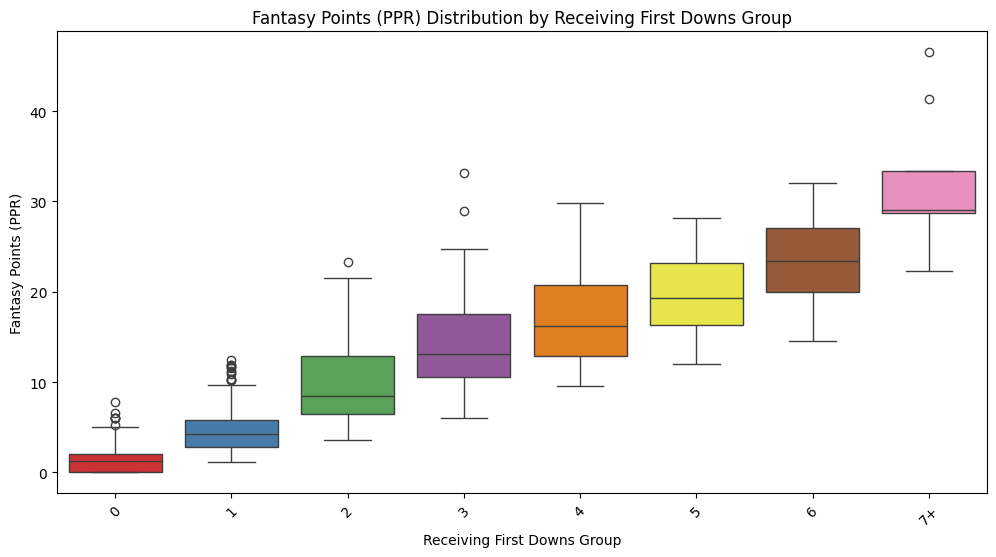

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame

# Create bins for receiving_first_downs
bins = [-1, 0, 1, 2, 3, 4, 5, 6, float('inf')]
labels = ['0', '1', '2', '3', '4', '5', '6', '7+']
df['receiving_first_downs_group'] = pd.cut(df['receiving_first_downs'], bins=bins, labels=labels, right=True)

# Plot the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='receiving_first_downs_group', y='fantasy_points_ppr', data=df, palette='Set1')
plt.title('Fantasy Points (PPR) Distribution by Receiving First Downs Group')
plt.xlabel('Receiving First Downs Group')
plt.ylabel('Fantasy Points (PPR)')
plt.xticks(rotation=45)
plt.show()

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_7419/900651058.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='receptions', data=df, palette='Set1')


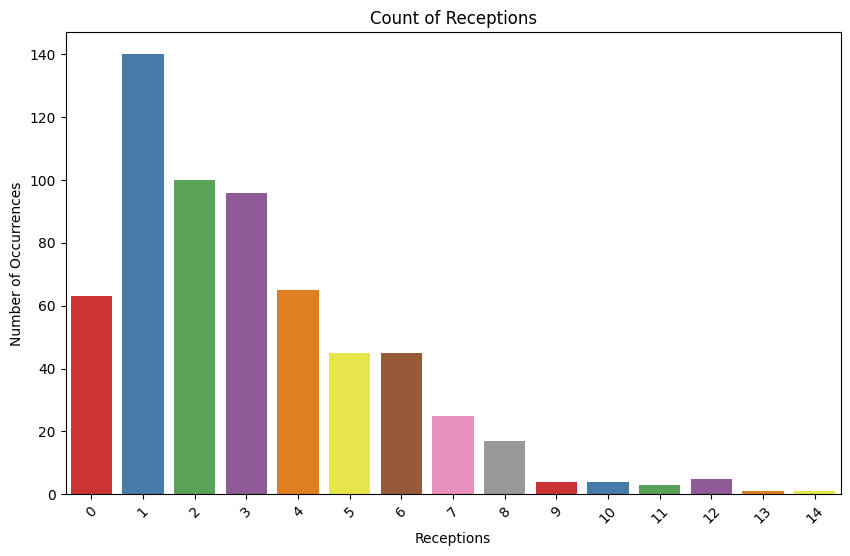

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(x='receptions', data=df, palette='Set1')
plt.title('Count of Receptions')
plt.xlabel('Receptions')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

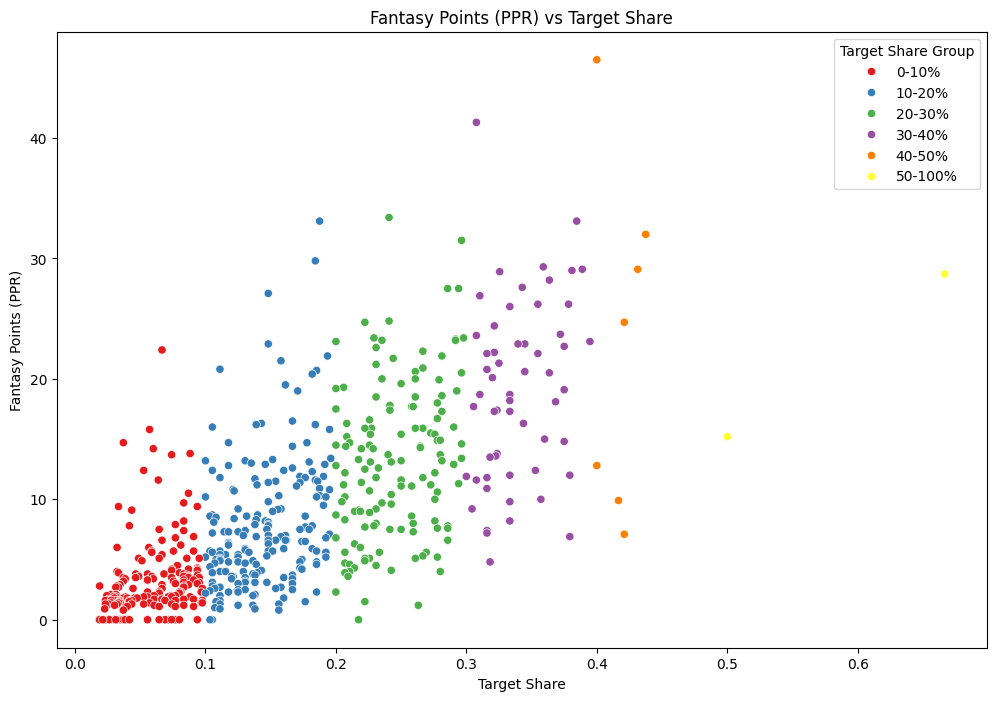

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a new column for target share categories
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-100%']
df['target_share_group'] = pd.cut(df['target_share'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='target_share', y='fantasy_points_ppr', hue='target_share_group', palette='Set1')
plt.title('Fantasy Points (PPR) vs Target Share')
plt.xlabel('Target Share')
plt.ylabel('Fantasy Points (PPR)')
plt.legend(title='Target Share Group')
plt.show()

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_7419/4288844298.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target_share_group', y='fantasy_points_ppr', data=df, palette='Set1')


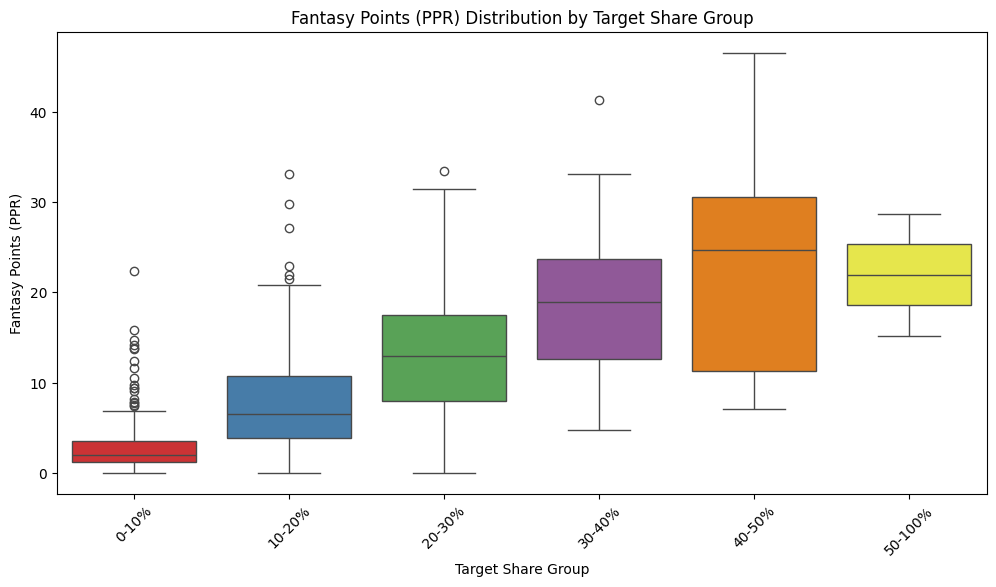

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and 'target_share_group' is already created
plt.figure(figsize=(12, 6))
sns.boxplot(x='target_share_group', y='fantasy_points_ppr', data=df, palette='Set1')
plt.title('Fantasy Points (PPR) Distribution by Target Share Group')
plt.xlabel('Target Share Group')
plt.ylabel('Fantasy Points (PPR)')
plt.xticks(rotation=45)
plt.show()

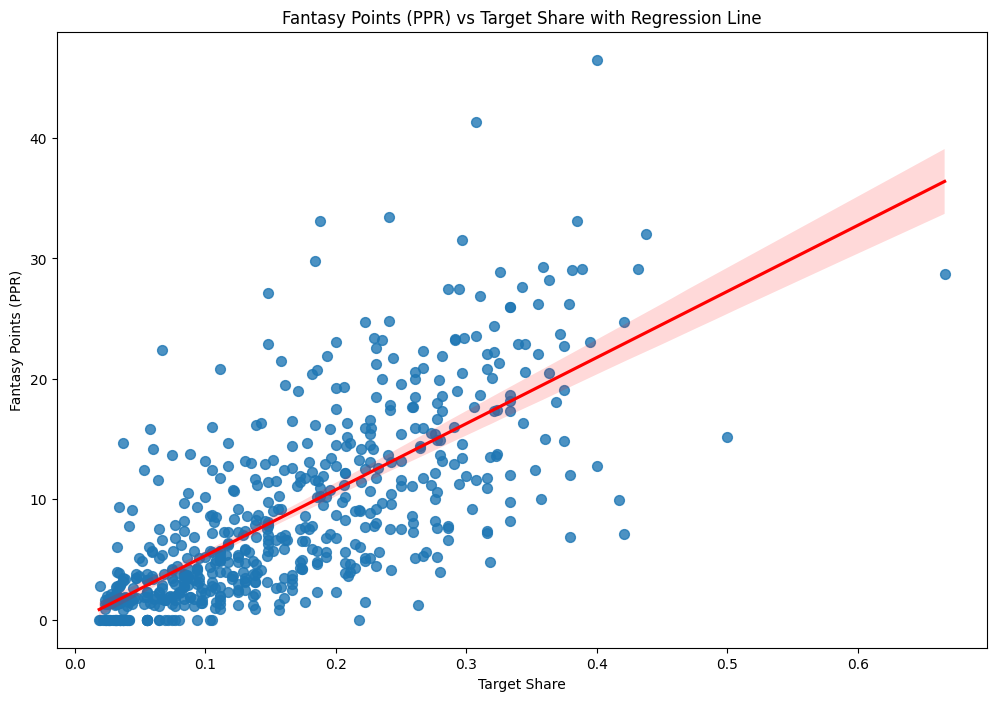

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a new column for target share categories
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-100%']
df['target_share_group'] = pd.cut(df['target_share'], bins=bins, labels=labels, right=False)

# Plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='target_share', y='fantasy_points_ppr', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Target Share')
plt.ylabel('Fantasy Points (PPR)')
plt.title('Fantasy Points (PPR) vs Target Share with Regression Line')

# Display the plot
plt.show()

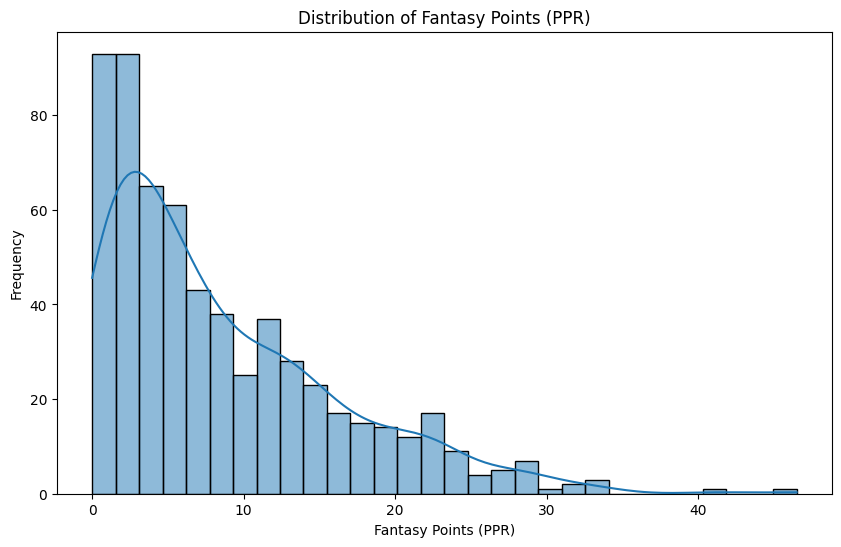

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(sorted_wr_data['fantasy_points_ppr'], bins=30, kde=True)
plt.title('Distribution of Fantasy Points (PPR)')
plt.xlabel('Fantasy Points (PPR)')
plt.ylabel('Frequency')
plt.show()

In [105]:
# Update the features list with actual column names from your DataFrame
features = ['receptions', 'receiving_yards', 'receiving_first_downs', 'target_share']  # Example features

# Select features and target
X = df[features]
y = df['performance_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8540540540540541
Classification Report:
               precision    recall  f1-score   support

     Average       0.76      0.75      0.76        56
        High       0.87      0.86      0.86        69
         Low       0.92      0.95      0.93        60

    accuracy                           0.85       185
   macro avg       0.85      0.85      0.85       185
weighted avg       0.85      0.85      0.85       185



In [117]:
# Group by player and calculate average statistics
player_aggregates = df.groupby('player_id').agg({
    'receptions': 'mean',
    'receiving_yards': 'mean',
    'receiving_tds': 'mean',
    'receiving_first_downs': 'mean',
    'targets': 'mean',
    'fantasy_points_ppr': ['mean', 'std']  # Calculate mean and standard deviation
}).reset_index()

# Rename columns for clarity
player_aggregates.columns = ['player_id', 'avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                             'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 'std_fantasy_points']



In [127]:
# Sort players by average fantasy points in descending order
player_aggregates = player_aggregates.sort_values(by='avg_fantasy_points', ascending=False)

# Select the top 80 players
top_80_players = player_aggregates.head(80)


# Reclassify performance within the top 80 players
top_80_players['performance_category'] = pd.qcut(top_80_players['avg_fantasy_points'], q=3, labels=['Low', 'Average', 'High'])

# Calculate confidence as the inverse of standard deviation
top_80_players['confidence'] = 1 / top_80_players['std_fantasy_points']

# Merge with original DataFrame to get player names
top_80_players = top_80_players.merge(df[['player_id', 'player_name']].drop_duplicates(), on='player_id')

# Display the list of players with confidence
#print(top_80_players[['player_name', 'avg_fantasy_points', 'performance_category', 'confidence']])

# Set pandas options to display more rows
pd.set_option('display.max_rows', 80)  # Adjust the number as needed

# Display the list of top 50 players with confidence
print(top_80_players[['player_name', 'avg_fantasy_points', 'performance_category', 'confidence', 'std_fantasy_points']])

         player_name  avg_fantasy_points performance_category  confidence  std_fantasy_points
0           M.Nabers               22.90                 High        0.13                7.95
1            A.Brown               22.90                 High         NaN                 NaN
2            J.Chase               21.66                 High        0.07               13.78
3             R.Rice               21.63                 High        0.15                6.49
4          N.Collins               21.34                 High        0.12                8.61
5             C.Kupp               19.85                 High        0.06               17.18
6        J.Jefferson               19.00                 High        0.29                3.39
7             J.Reed               18.28                 High        0.09               11.28
8           C.Godwin               17.76                 High        0.18                5.71
9        A.St. Brown               17.12                 Hig

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_7419/1547121775.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_80_players['performance_category'] = pd.qcut(top_80_players['avg_fantasy_points'], q=3, labels=['Low', 'Average', 'High'])
/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_7419/1547121775.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_80_players['confidence'] = 1 / top_80_players['std_fantasy_points']


In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Define the feature columns
feature_columns = [
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs',
    'target_share'
]

# Extract features and labels
X = df[feature_columns]
y = df['fantasy_points_ppr']  # Continuous target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the k-NN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_scaled, y_train)

# Predict fantasy scores using the trained k-NN regressor
y_test_pred = knn_regressor.predict(X_test_scaled)

# Create a DataFrame for the test set to store predictions
test_set_with_predictions = X_test.copy()
test_set_with_predictions['predicted_fantasy_score'] = y_test_pred
test_set_with_predictions['player_name'] = df.loc[X_test.index, 'player_name']

# Rank WRs based on predicted fantasy scores and select the top 5
top_5_wr = test_set_with_predictions.sort_values(by='predicted_fantasy_score', ascending=False).head(20)

# Display the top 5 WRs
print(top_5_wr[['player_name', 'predicted_fantasy_score']])

      player_name  predicted_fantasy_score
897      D.London                28.60    
1446   M.Harrison                28.00    
996      G.Wilson                27.62    
675      D.Mooney                26.48    
78        M.Evans                25.52    
1101      D.Wicks                25.18    
700        C.Lamb                22.74    
834   A.St. Brown                21.68    
986      A.Pierce                21.42    
702        C.Lamb                21.28    
895      D.London                20.56    
835   A.St. Brown                20.46    
1368    X.Legette                20.20    
399        C.Kirk                20.06    
566    T.McLaurin                18.96    
672      D.Mooney                18.78    
1308       R.Rice                18.28    
554     D.Metcalf                17.04    
398        C.Kirk                15.80    
433       K.Hodge                15.64    
